# Auto-Playlists

### Goal is to generate K playlists from list of songs using Spotify's python API

In [27]:
import spotipy
import numpy as np
import pandas as pd

from ipywidgets import widgets, Layout

from spotipy.oauth2 import SpotifyClientCredentials

# My Spotify credentials please don't steal
from credentials import CLIENT_ID, CLIENT_SECRET
SPOTIFY_USERNAME = "tellezsanti"

In [28]:
# API Login
client_credentials_manager = SpotifyClientCredentials(client_id = CLIENT_ID, client_secret = CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [49]:
playlists = sp.user_playlists(SPOTIFY_USERNAME)['items']

playlist_ids = {}

for playlist in playlists:
    playlist_ids[playlist['name']] = playlist['id']
    
plist_name = widgets.Select(
    options = playlist_ids.keys(),
    value = list(playlist_ids.keys())[0],
    description = 'Playlist:',
    disabled = False,
    layout = Layout(width='30%', height='180px')
)

display(plist_name)

Select(description='Playlist:', layout=Layout(height='180px', width='30%'), options=('test', "kal's overplayed…

#### Experiment
* For the purposes of this example, I created a dummy playlist "test" with 30 songs from 3 distinct genres: Classical, Electronic and Rap
* Goal is to see if clustering can correctly identify the different groups

In [50]:
PLAYLIST_ID = playlist_ids[plist_name.value]

# Getting tracks of the playlist
tracks = sp.user_playlist_tracks(user = 'tellezsanti', playlist_id = PLAYLIST_ID)
tracks_uri_list = [x['track']['uri'] for x in tracks['items']]

# Getting features of tracks
features = []
for i in tracks_uri_list:
    features = features + sp.audio_features(i)

# Creating feature dataframe
cols_to_drop = ['id', 'analysis_url', 'key', 'time_signature', 'track_href', 'type', 'uri', 'mode', 'duration_ms']
features_df = pd.DataFrame(features).drop(cols_to_drop, axis=1)

#### Provided features to be used in clustering:
* **Danceability** - describes how suitable a track is for dancing
* **Energy** - represents a perceptual measure of intensity and activity
* **Loudness** - overall loudness of a track in decibels
* **Speechiness** - detects the presence of spoken words in a track
* **Acousticness** - confidence measure of whether the track is acoustic
* **Instrumentalness** - predicts whether a track contains no vocals
* **Liveness** - detects the presence of an audience in the recording
* **Valence** - a measure describing the musical positiveness conveyed by a track
* **Tempo** - overall estimated tempo of a track in beats per minute

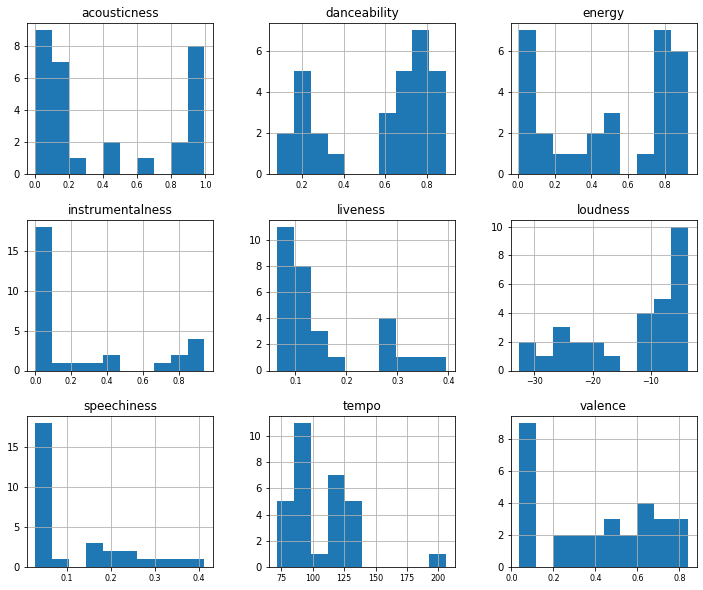

In [51]:
features_df.hist(xlabelsize=8, figsize=(12,10));

In [56]:
from sklearn.cluster import KMeans

# Scaling
features_df = (features_df - features_df.mean()) / features_df.std()
# for col in ['loudness', 'tempo']:
#     features_df[col] = ((features_df[col] - features_df[col].min()) / (features_df[col].max() - features_df[col].min()))
    
# Training and Predicting
kmeans_model = KMeans(n_clusters = 3, random_state=3).fit(features_df)
preds = kmeans_model.predict(features_df)

In [57]:
# Extracting song and artist names
songs = [x['track']['name'] for x in tracks['items']]
artists = [x['track']['artists'] for x in tracks['items']]

# Concatenating multiple artist names
artist_list = []
for group in artists:
    artist_group = []
    for person in group:
        artist_group.append(person['name'])
    artist_list.append(', '.join(artist_group))

# Adding predictions to dataframe
features_df['cluster'] = preds

# Grouping clusters to see the averages
clusters = features_df.groupby('cluster').agg('mean')
clusters

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,
0,-1.307376,-1.233400,-1.242319,-0.674451,1.301504,1.192058,-0.567975,-1.096541,-0.440848
1,0.463446,0.970090,0.818532,-0.149259,-0.772589,-0.587821,0.263370,0.317389,0.857570
2,0.886206,0.184779,0.379926,0.931818,-0.501840,-0.606062,0.309187,0.830459,-0.558310


In [58]:
# listing clusters

song_clusters = np.concatenate((np.array(songs)[:, np.newaxis], preds[:, np.newaxis]), axis = 1)

for c in np.unique(song_clusters[:, 1]):
    print(c)
    print(list(song_clusters[song_clusters[:, 1] == c, 0]))

0
['The Well-Tempered Clavier: Book 1, BWV 846-869: 1. Prelude in C Major, BWV 846', 'The Lark Ascending', 'Handel / Orch. Hale: Keyboard Suite in D Minor, HWV 437: III. Sarabande', 'Bagatelle No. 25 in A Minor, "Für Elise", WoO 59', 'Rhapsody On A Theme Of Paganini, Op.43: Variation 18. Andante cantabile', 'Cello Concerto in E Minor, Op.85 (1988 Digital Remaster): I. Adagio - Moderato', 'Rhapsody In Blue', 'Cello Suite No. 1 in G Major, BWV 1007: I. Prélude', 'Meditation: Méditation from Thaïs', 'Gnossienne No. 1']
1
['Pretty Please', 'Lasting Lover', 'The Recipe', 'Break This Habit (feat. Kiko Bun)', 'Fire (with Elderbrook)', 'Hey Baby (feat. Gia Koka)', 'Follow (with Jeremih)', 'Coffee (Give Me Something)', 'Watch Your Step', 'SAD - Imanbek xxx Remix', "93 'Til Infinity"]
2
["Passin' Me By", 'Electric Relaxation', 'The Look of Love - Remix', 'The Truth', 'Fall in Love', 'I Juswanna Chill', 'Rebirth Of Slick (Cool Like Dat)', 'Grown Man Sport', 'Swan Lake']


In [47]:
songs

['The Well-Tempered Clavier: Book 1, BWV 846-869: 1. Prelude in C Major, BWV 846',
 'The Lark Ascending',
 'Handel / Orch. Hale: Keyboard Suite in D Minor, HWV 437: III. Sarabande',
 'Bagatelle No. 25 in A Minor, "Für Elise", WoO 59',
 'Rhapsody On A Theme Of Paganini, Op.43: Variation 18. Andante cantabile',
 'Cello Concerto in E Minor, Op.85 (1988 Digital Remaster): I. Adagio - Moderato',
 'Rhapsody In Blue',
 'Cello Suite No. 1 in G Major, BWV 1007: I. Prélude',
 'Meditation: Méditation from Thaïs',
 'Gnossienne No. 1',
 'Pretty Please',
 'Lasting Lover',
 'The Recipe',
 'Break This Habit (feat. Kiko Bun)',
 'Fire (with Elderbrook)',
 'Hey Baby (feat. Gia Koka)',
 'Follow (with Jeremih)',
 'Coffee (Give Me Something)',
 'Watch Your Step',
 'SAD - Imanbek xxx Remix',
 "Passin' Me By",
 'Electric Relaxation',
 'The Look of Love - Remix',
 "93 'Til Infinity",
 'The Truth',
 'Fall in Love',
 'I Juswanna Chill',
 'Rebirth Of Slick (Cool Like Dat)',
 'Grown Man Sport',
 'Swan Lake']